# Supplement

In [1]:
import scipy
import numpy as np
from scipy.integrate import solve_ivp

import pandas as pd

import tensorflow as tf
from keras import initializers

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Solution of ODEs


In [2]:
class Committee_machine:
    
    
    def __init__(self,K,M,eta,tStop,alpha,beta,var,a=6,O=1,N=10000,sigma=0):
        self.rnd=a
        self.tStop=tStop
        np.random.seed(a)
        self.K=K
       # self.Q0=Q0
        self.alpha=alpha
        self.beta=beta
        self.M=M
        self.var=var
        self.eta=eta
        self.N=N
        self.O=O
        self.sigma=sigma
        
        self.R0=np.random.normal(0,np.sqrt(var)/np.sqrt(N),size=(self.K,self.M))  
        #print(self.R0)
        #self.R0=R0
        self.T=np.zeros((self.M,self.M))
        for i in range(0,self.M):
            for j in range(0,self.M):
                if i==j:
                    self.T[i,j]=1
        
        
        
      
        
    def Q_ij(self):
        np.random.seed(self.rnd)
        Q_ij=np.zeros((self.K,self.K))
        for i in range(0,self.K):
            for j in range(0,self.K):
                
                if i==j:
                    Q_ij[i,j]=np.random.normal(np.sqrt(self.var),np.sqrt(2)*self.var**2*1/np.sqrt(self.N))
                   
                else:
                    Q_ij[i,j]=np.random.normal(0,self.var**2*1/np.sqrt(self.N))
        return   Q_ij #self.Q0
    
    
       
    def I_4_sstt(self,i,k,n,m,R,Q):
        C11=Q[i][i]
        C12=Q[i][k]
        C13=R[i][n]
        C14=R[i][m]
        
        C21=C12
        C22=Q[k][k]
        C23=R[k][n]
        C24=R[k][m]
        
        C31=C13
        C32=C23
        C33=self.T[n][n]
        C34=self.T[n][m]
        
        C41=C14
        C42=C24
        C43=C34
        C44=self.T[m][m]
        L4=(1+C11)*(1+C22)-C12**2
        L0=L4*C34-C23*C24*(1+C11)-C13*C14*(1+C22)+C12*C13*C24+C12*C14*C23
        L1=L4*(1+C33)-C23**2*(1+C11)-C13**2*(1+C22)+2*C12*C13*C23
        L2=L4*(1+C44)-C24**2*(1+C11)-C14**2*(1+C22)+2*C12*C14*C24
        
        return 4/(np.pi**2) * 1/np.sqrt(L4)*np.arcsin(L0/(np.sqrt(L1)*np.sqrt(L2)))
    
    def I_4_ssst(self,i,k,j,n,R,Q):
        C11=Q[i][i]
        C12=Q[i][k]
        C13=Q[i][j]
        C14=R[i][n]
        
        C21=C12
        C22=Q[k][k]
        C23=Q[k][j]
        C24=R[k][n]
        
        C31=C13
        C32=C23
        C33=Q[j][j]
        C34=R[j][n]
        
        C41=C14
        C42=C24
        C43=C34
        C44=self.T[n][n]
        L4=(1+C11)*(1+C22)-C12**2
        L0=L4*C34-C23*C24*(1+C11)-C13*C14*(1+C22)+C12*C13*C24+C12*C14*C23
        L1=L4*(1+C33)-C23**2*(1+C11)-C13**2*(1+C22)+2*C12*C13*C23
        L2=L4*(1+C44)-C24**2*(1+C11)-C14**2*(1+C22)+2*C12*C14*C24
        
        return 4/(np.pi**2) * 1/np.sqrt(L4)*np.arcsin(L0/(np.sqrt(L1)*np.sqrt(L2)))
    
    def I_4_ssss(self,i,k,j,l,R,Q):
        C11=Q[i][i]
        C12=Q[i][k]
        C13=Q[i][j]
        C14=Q[i][l]
        
        C21=C12
        C22=Q[k][k]
        C23=Q[k][j]
        C24=Q[k][l]
        
        C31=C13
        C32=C23
        C33=Q[j][j]
        C34=Q[j][l]
        
        C41=C14
        C42=C24
        C43=C34
        C44=Q[l][l]
        L4=(1+C11)*(1+C22)-C12**2
        L0=L4*C34-C23*C24*(1+C11)-C13*C14*(1+C22)+C12*C13*C24+C12*C14*C23
        L1=L4*(1+C33)-C23**2*(1+C11)-C13**2*(1+C22)+2*C12*C13*C23
        L2=L4*(1+C44)-C24**2*(1+C11)-C14**2*(1+C22)+2*C12*C14*C24
        
        return 4/(np.pi**2)*1/np.sqrt(L4)*np.arcsin(L0/(np.sqrt(L1)*np.sqrt(L2)))
       
    #sum over student    
    def I_3_sts(self,i,n,j,R,Q):
        C23=R[j][n]
        C32=C23
        C11=Q[i][i]
        C12=R[i][n]
        C21=C12
        C13=Q[i][j]
        C22=self.T[n][n]
        C33=Q[j][j]
        C31=C13
     
        L3=(1+C11)*(1+C33)-C13**2
        return 2/np.pi*1/np.sqrt(L3)*((C23*(1+C11)-C12*C13)/(1+C11))
    
    #sum over teacher
    def I_3_stt(self,i,n,m,R,Q):
        C23=self.T[n][m]
        C32=C23
        C11=Q[i][i]
        C12=R[i][n]
        C21=C12
        C13=R[i][m]
        C22=self.T[n][n]
        C33=self.T[m][m]
        C31=C13
        L3=(1+C11)*(1+C33)-C13**2
        return 2/np.pi*1/np.sqrt(L3)*((C23*(1+C11)-C12*C13)*1/(1+C11))
    
    def I_3_sst(self,k,i,m,R,Q):
        C23=R[i][m]
        C32=C23
        C11=Q[k][k]
        C12=Q[k][i]
        C21=C12
        C13=R[k][m]
        C22=Q[i][i]
        C33=self.T[m][m]
        C31=C13
        
        L3=(1+C11)*(1+C33)-C13**2
        
        return 2/np.pi*1/np.sqrt(L3)*((C23*(1+C11)-C12*C13)/(1+C11))
        
        
    def I_3_sss(self,k,i,j,R,Q):
        C23=Q[j][i]
        C32=C23
        C11=Q[k][k]
        C12=Q[k][i]
        C21=C12
        C13=Q[k][j]
        C22=Q[i][i]
        C33=Q[j][j]
        C31=C13
        
        L3=(1+C11)*(1+C33)-(C13**2)
        return 2/np.pi*1/np.sqrt(L3)*((C23*(1+C11)-C12*C13)/(1+C11))
    
    def J_2_ss(self,i,k,R,Q):
        C11=Q[i][i]
        C12=Q[i][k]
        C13=C12
        C22=Q[k][k]
        
        return 2/np.pi*(1+C11+C22+C11*C22-C12**2)**(-1/2)
        
    def deriv_R(self,i,n,R,Q):
        
        I_3_i_n_j=0
        I_3_i_n_m=0
        for j in range(0,self.K):
            
            I_3_i_n_j+=self.I_3_sts(i,n,j,R,Q)
            
        for m in range(0,self.M):
            I_3_i_n_m+=self.I_3_stt(i,n,m,R,Q)
            
            
        a=self.eta*self.alpha*(self.beta*I_3_i_n_m-self.alpha*I_3_i_n_j)
        
        return a
    
    def deriv_Q(self,i,k,R,Q):
        
        I_3_i_k_m=0
        I_3_i_k_j=0
        
        for j in range(0,self.K):
            
            I_3_i_k_j+=self.I_3_sss(i,k,j,R,Q)
            
        for m in range(0,self.M):
            I_3_i_k_m+=self.I_3_sst(i,k,m,R,Q)
           
        I_3_k_i_j=0
        I_3_k_i_m=0
        for j in range(0,self.K):
            
            I_3_k_i_j+=self.I_3_sss(k,i,j,R,Q)
            
        for m in range(0,self.M):
            
            I_3_k_i_m+=self.I_3_sst(k,i,m,R,Q)
            
        I_4_i_k_n_m=0
        for n in range(0,self.M):
            for m in range(0,self.M):
                I_4_i_k_n_m+=self.I_4_sstt(i,k,n,m,R,Q)
                
        I_4_i_k_j_n=0
        for j in range(0,self.K):
            for n in range(0,self.M):
                I_4_i_k_j_n+=self.I_4_ssst(i,k,j,n,R,Q)
                
        I_4_i_k_j_l=0        
        for j in range(0,self.K):
            for l in range(0,self.K):
                
                I_4_i_k_j_l+=self.I_4_ssss(i,k,j,l,R,Q)
                
                
        J_2_i_k=self.J_2_ss(i,k,R,Q)
        
        if self.O==1:                                       
            a=self.eta*self.alpha*(self.beta*I_3_i_k_m-self.alpha*I_3_i_k_j)+self.eta*self.alpha*(self.beta*I_3_k_i_m-self.alpha*I_3_k_i_j)#+self.eta*(self.alpha*self.beta**2*I_4_i_k_n_m-2*self.alpha**2*self.beta*I_4_i_k_j_n+self.alpha**3*I_4_i_k_j_l)                                   
        elif self.O==2:                                
            a=self.eta*self.alpha*(self.beta*I_3_i_k_m-self.alpha*I_3_i_k_j)+self.eta*self.alpha*(self.beta*I_3_k_i_m-self.alpha*I_3_k_i_j)+self.eta**2*self.alpha**2*(self.beta**2*I_4_i_k_n_m-2*self.alpha*self.beta*I_4_i_k_j_n+self.alpha**2*I_4_i_k_j_l)                                   
        else:
             a=self.eta*self.alpha*(self.beta*I_3_i_k_m-self.alpha*I_3_i_k_j)+self.eta*self.alpha*(self.beta*I_3_k_i_m-self.alpha*I_3_k_i_j)+self.eta**2*self.alpha**2*(self.beta**2*I_4_i_k_n_m-2*self.alpha*self.beta*I_4_i_k_j_n+self.alpha**2*I_4_i_k_j_l+self.sigma**2*J_2_i_k)                                   
        
        return a
    
    def func(self,t,y):
    
        R=np.zeros((self.K,self.M))  
        Q=np.zeros((self.K,self.K))
        
        R=y[slice(0,self.K*self.M)].reshape((self.K,self.M))
        
        Q=y[slice(self.K*self.M,self.K*self.M+self.K**2)].reshape((self.K,self.K))
        
        derivs=[]

        for i in range(0,self.K):
            for n in range(0,self.M): 
                
                
                derivs.append(self.deriv_R(i,n,R,Q))
                
        for i in range(0,self.K):
            
            for k in range(0,self.K):
        
                derivs.append(self.deriv_Q(i,k,R,Q))            
               
             
        return derivs
    
    
    def sol(self):
        tStop = self.tStop
        tInc =1
        t = np.arange(0., tStop, tInc)

        y0=np.asarray(np.concatenate((self.R0.reshape(self.K*self.M),self.Q_ij().reshape(self.K*self.K))))
       # print(self.Q_ij())
     
        
        psoln =solve_ivp(self.func,[0,tStop],y0,t_eval=t,atol=1e-12,rtol=1e-13)

        return psoln
    
    def epsilon(self):
        x=self.sol()
        z=x.y
        R_in=np.zeros((self.K,self.M))  
        Q_ik=np.zeros((self.K,self.K))
        epsilon=[]
        R=[]
        Q=[]
        
        
        for k in range(0,self.K**2+self.M*self.K):
         
                
            if k<self.M*self.K:
                    
                R.append(z[k])
            else:
                Q.append(z[k])
      
        R_in=np.asarray(R).reshape((self.K,self.M,int(len(x.t))))
        Q_ik=np.asarray(Q).reshape((self.K,self.K,int(len(x.t))))
        
        for l in range(0,int(len(x.t))):  
        
            T_nm=self.T
            a=0
            for i in range(0,self.K):
                for k in range(0,self.K):
                    a+=np.arcsin(Q_ik[i,k,l]/(np.sqrt(((1+Q_ik[i,i,l])))*np.sqrt((1+Q_ik[k,k,l]))))
            b=0
            for n in range(0,self.M):
                for m in range(0,self.M):
                    b+=np.arcsin(T_nm[n,m]/(np.sqrt(((1+T_nm[m,m])))*np.sqrt((1+T_nm[n,n]))))
                
            c=0
            for i in range(0,self.K):
                for n in range(0,self.M):
                    c+=np.arcsin(R_in[i,n,l]/(np.sqrt(((1+Q_ik[i,i,l])))*np.sqrt((1+T_nm[n,n]))))
            
            epsilon.append(1/np.pi*(self.alpha**2*a+self.beta**2*b-2*self.alpha*self.beta*c))   
       
            
        return x.t,epsilon

## Simulation

In [3]:
#define activation function and loss function

def custom_activation(x):
    
    return tf.math.erf(x/(tf.sqrt(2.*N)))

def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return 1/2*tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

In [4]:
# teacher and student soft committee machine
def teacher_SCM(N,M,seed_M):
    teacher=tf.keras.models.Sequential([
                                  
    tf.keras.layers.Flatten(input_shape=(N,),name="layer0"),

      tf.keras.layers.Dense(M,activation=custom_activation,name="layer1",use_bias=False,kernel_initializer=initializers.RandomNormal(mean=0,stddev=1,seed=seed_M))])

    out=tf.keras.layers.Dense(1, activation=None,name="layerout",use_bias=False,kernel_initializer=initializers.RandomNormal(stddev=0,mean=np.sqrt(1/M)))
    out.trainable=False
    teacher.add(out)
    teacher.compile(
        optimizer=tf.keras.optimizers.SGD(1),
        loss=my_loss_fn,
        metrics=None,
   
    )
        
   
    return teacher



def student_SCM(N,K,M,seed_K):
    

    student=tf.keras.models.Sequential([
                                  
    tf.keras.layers.Flatten(input_shape=(N,),name="layer0"),
    tf.keras.layers.Dense(K,activation=custom_activation,name="layer1",use_bias=False,
    bias_initializer=initializers.Zeros(),
    kernel_initializer=initializers.random_normal(stddev=0.1,mean=0,seed=seed_K))])

    out=tf.keras.layers.Dense(1, 
    activation=None,name="layerout",use_bias=False,kernel_initializer=initializers.RandomNormal(stddev=0,mean=np.sqrt(M)/K))
    out.trainable=False
    student.add(out)
    student.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=K/np.sqrt(M)),
        loss=my_loss_fn,
        metrics=None,
   
    )


    return student

In [5]:
# online generalization error and its resolution

def online_gen(student,teacher,N,p,var):
    np.random.seed(None)
    x_test=np.random.normal(loc=0,scale=1,size=(5000,N))
    noise_test=np.random.normal(loc=0.,scale=np.sqrt(var),size=len(x_test)).astype('float32')
    train=[]
    error_test=[]
    end=int(p/N)
    weights=[]
    
    for alpha in range(0,end):
        # as alpha is defined as alpha=p/N, we use N examples at ones with dimension N to perform one update step
        # this defines the resolution
        x_train=np.random.normal(loc=0,scale=1,size=(N,N))
        noise_train=np.random.normal(loc=0,scale=np.sqrt(var),size=len(x_train)).astype('float32')
        labels=teacher(x_train)+tf.reshape(tf.convert_to_tensor(noise_train),(len(x_train),1))
        
        labels_test=teacher(x_test)+tf.reshape(tf.convert_to_tensor(noise_test),(len(x_test),1))
        error_test.append(np.mean(teacher.loss(labels_test,student(x_test))))
        
        # update the network after each representation of a particular example, therefore epoch=1 and batch_size=1
        history =student.fit(
           x=x_train,
            y=labels,
            epochs = 1,
            batch_size=1,
            verbose = 0,
            use_multiprocessing=True)
        
        
        train.append(history.history["loss"])
        
        #sometimes it is interesting to show the weight dynamics
        if alpha > 300:
            weights.append(student.weights[0].numpy()[:10,0])
            
        #print current time at pre-defined steps
        if not alpha%100:
            print(alpha)
        
    return np.array(error_test),np.array(train),weights

In [31]:
# set random seed to reproduce resutls

np.random.seed(1)
a=np.array(range(1,101))
seed_K=np.random.choice(a,size=50,replace=False)
seed_K

b=np.array(range(101,201))
seed_M=np.random.choice(b,size=50,replace=False)

## One-pass stochastic gradient descent training of a SCM

In [71]:
# corresponds to Fig. 5 in the Supplemental Material

N=2500
end=800
SCM1=[]

for i in range(0,1):
    error=[]
    teacher=teacher_SCM(N,2,seed_M=seed_M[i+4])
    for K in [4]:
        
        student=student_SCM(N,K,2,seed_K=seed_K[i+7])
        #print(student.weights[0])
        h=online_gen(student,teacher,N,N*end,0.0)[0]
        
        error.append(h)
        
        
    SCM1.append(np.array(error))
    df=pd.DataFrame(error)
    #df.to_csv("run_SCM_random_teacher_N2500_"+str(i)+".csv",sep=";",header=None)
    print(i,flush=True)

0
100
200
300
400
500
600
700
0


In [ ]:
# corresponds to Fig. S6 in the Supplemental Material
N=2500
end=300
SCM3=[]
Stu=[]
weights=[]
for i in range(0,1):
    error=[]
    teacher=teacher_SCM(N,2,seed_M=91)
    for K in [2]:
        
        student=student_SCM(N,K,2,seed_K=11)
        
        
        h,b,w=online_gen(student,teacher,N,N*end,0.)
        weights.append(w)
        
        error.append(h)
        
    SCM3.append(np.array(error))
    print(i,flush=True)

In [81]:
# instead of using SCM3, we load data after 5 different initializations for Fig. S6 for previous runs
#df=pd.read_csv("5runs_SCM_random_teacher_N2500.csv",sep=";",header=None)
#df=df.drop(0,axis=1)

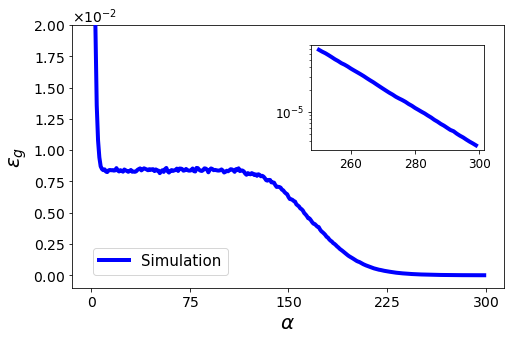

In [70]:
# corresponds to Fig. 6 in the Supplemental Material

t = np.arange(0., 300, 1)

fig=plt.figure(figsize=(8,5))
ax = plt.axes()
plt.plot(t[0:300],df.values[0:300],color="blue",linestyle="-",linewidth=4,zorder=4)

    
plt.xlabel(r"$\alpha$",size=20)
plt.ylabel(r"$\epsilon_g$",size=20)
#plt.legend(["Simulation","Solution of ODEs","ODEs"],fontsize=15,loc=(0.05,0.05),labelspacing=0.3)


plt.xticks([0,75,150,225,300],fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.001,top=0.02)

plt.gcf().subplots_adjust(bottom=0.15,left=0.15)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,10),useMathText=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,10),useMathText=True)
plt.gca().yaxis.offsetText.set_fontsize(14)
fig.patch.set_facecolor(None,)
fig.patch.set_alpha(0)

axins2 = inset_axes(ax, width="40%", height="40%",loc="upper right",borderpad=2)

axins2.semilogy(t[250:300],df.values[250:300],color="blue",linestyle="-",linewidth=4,zorder=4)

#axins2.loglog(t[250:300],err_mean3[250:300],linewidth=4,color="red",zorder=5,linestyle="--")

axins2.tick_params(axis="x",labelsize=12)
axins2.tick_params(axis="y",labelsize=12)


axins2.tick_params(axis='both', which='minor', labelsize=10)


#plt.savefig("5rund_N2500_K2_M2_with_ODEs.pdf",dpi=1200,bbox_inches='tight')
plt.show();

In [ ]:
# here just one initialization is used for demonstration purposes
# mean value is calculated for different initialization runs

SCM2=np.mean(np.array(SCM1)[:,0],axis=0)

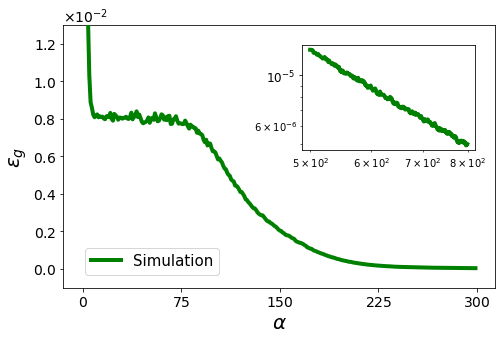

In [87]:

# corresponds to Fig. S7 in the Supplemental Material
# here different range and just one initialization

t = np.arange(0., 800, 1)

fig=plt.figure(figsize=(8,5))
ax = plt.axes()
plt.plot(t[0:300],SCM2[0:300],color="green",linestyle="-",linewidth=4,zorder=4)

    
plt.xlabel(r"$\alpha$",size=20)
plt.ylabel(r"$\epsilon_g$",size=20)
#plt.legend(["Simulation","Solution of ODEs","ODEs"],fontsize=15,loc=(0.05,0.05),labelspacing=0.3)


plt.xticks([0,75,150,225,300],fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.001,top=0.013)

plt.gcf().subplots_adjust(bottom=0.15,left=0.15)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,10),useMathText=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,10),useMathText=True)
plt.gca().yaxis.offsetText.set_fontsize(14)
fig.patch.set_facecolor(None,)
fig.patch.set_alpha(0)

axins2 = inset_axes(ax, width="40%", height="40%",loc="upper right",borderpad=2)

axins2.loglog(t[500:800],SCM2[500:800],color="green",linestyle="-",linewidth=4,zorder=4)



axins2.tick_params(axis="x",labelsize=12)
axins2.tick_params(axis="y",labelsize=12)


plt.gca().yaxis.offsetText.set_fontsize(10)
axins2.tick_params(axis='both', which='minor', labelsize=10)


#plt.savefig("5rund_N2500_K2_M2_with_ODEs.pdf",dpi=1200,bbox_inches='tight')
plt.show();

## Heatmap for teacher size M=3

In [ ]:
# use again solutions of ODEs for order parameters

R=[]
Q=[]
a2=Committee_machine(K=9,M=3,eta=9/np.sqrt(3),alpha=np.sqrt(3)/9,beta=1/np.sqrt(3),tStop=15000,var=10**-4,a=6,N=10000,O=1)
solution2=a2.sol()
R=solution2.y[slice(0,27)]
Q=solution2.y[slice(27,27+81)]

In [ ]:
dfR=pd.DataFrame(R)
dfQ=pd.DataFrame(Q)

In [16]:
# laod and upload data

#dfR.to_csv("Rin_K9_M3.csv",sep=";",header=None)
#dfQ.to_csv("Qij_K9_M3.csv",sep=";",header=None)
dfR=pd.read_csv("Rin_K9_M3.csv",sep=";",header=None)
dfQ=pd.read_csv("Qij_K9_M3.csv",sep=";",header=None)
dfQ=dfQ.drop(0,axis=1)
dfR=dfR.drop(0,axis=1)

In [17]:
# new order

RR=np.zeros((9,3))
dfR.values[:,14999].reshape((9,3))[5,0]


RR[0,0]=dfR.values[:,14999].reshape((9,3))[5,0]
RR[0,1]=dfR.values[:,14999].reshape((9,3))[5,1]
RR[0,2]=dfR.values[:,14999].reshape((9,3))[5,2]

RR[1,0]=dfR.values[:,14999].reshape((9,3))[6,0]
RR[1,1]=dfR.values[:,14999].reshape((9,3))[6,1]
RR[1,2]=dfR.values[:,14999].reshape((9,3))[6,2]

RR[2,0]=dfR.values[:,14999].reshape((9,3))[7,0]
RR[2,1]=dfR.values[:,14999].reshape((9,3))[7,1]
RR[2,2]=dfR.values[:,14999].reshape((9,3))[7,2]

RR[3,0]=dfR.values[:,14999].reshape((9,3))[0,0]
RR[3,1]=dfR.values[:,14999].reshape((9,3))[0,1]
RR[3,2]=dfR.values[:,14999].reshape((9,3))[0,2]

RR[4,0]=dfR.values[:,14999].reshape((9,3))[3,0]
RR[4,1]=dfR.values[:,14999].reshape((9,3))[3,1]
RR[4,2]=dfR.values[:,14999].reshape((9,3))[3,2]

RR[5,0]=dfR.values[:,14999].reshape((9,3))[4,0]
RR[5,1]=dfR.values[:,14999].reshape((9,3))[4,1]
RR[5,2]=dfR.values[:,14999].reshape((9,3))[4,2]

RR[6,0]=dfR.values[:,14999].reshape((9,3))[1,0]
RR[6,1]=dfR.values[:,14999].reshape((9,3))[1,1]
RR[6,2]=dfR.values[:,14999].reshape((9,3))[1,2]

RR[7,0]=dfR.values[:,14999].reshape((9,3))[2,0]
RR[7,1]=dfR.values[:,14999].reshape((9,3))[2,1]
RR[7,2]=dfR.values[:,14999].reshape((9,3))[2,2]

RR[8,0]=dfR.values[:,14999].reshape((9,3))[8,0]
RR[8,1]=dfR.values[:,14999].reshape((9,3))[8,1]
RR[8,2]=dfR.values[:,14999].reshape((9,3))[8,2]

<ipython-input-18-065f29c47a84>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(alpha,size=28)
<ipython-input-18-065f29c47a84>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(beta,size=28)


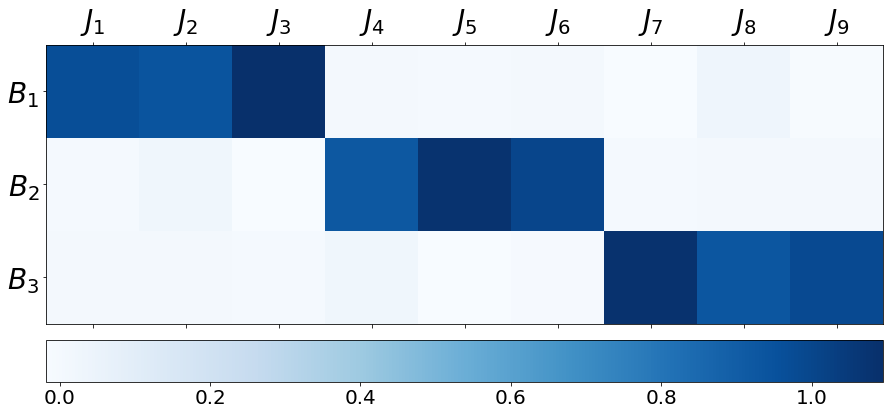

In [18]:
# Fig. S2

fig, ax = plt.subplots(figsize=(15,15))

min_val, max_val = -1, 1

intersection_matrix = (RR.T)
cax=ax.matshow(intersection_matrix, cmap=plt.cm.Blues,)
cbar=fig.colorbar(cax,orientation="horizontal",pad=0.02,)
cbar.ax.tick_params(labelsize=20)
alpha = [r"$J_1$",r"$J_1$",r"$J_2$",r"$J_3$",r"$J_4$",r"$J_5$",r"$J_6$",r"$J_7$",r"$J_8$",r"$J_9$"]
beta=[r"$B_1$",r"$B_1$",r"$B_2$",r"$B_3$",]
ax.set_xticklabels(alpha,size=28)
ax.set_yticklabels(beta,size=28)
#plt.savefig("heat_map_R_9_3_2_ordered.pdf",bbox_inches="tight")
plt.show();

In [19]:
# new order

QQ=np.zeros((9,9))
QQ[0,0]=dfQ.values[:,14999].reshape((9,9))[5,5]
QQ[0,1]=dfQ.values[:,14999].reshape((9,9))[5,6]
QQ[0,2]=dfQ.values[:,14999].reshape((9,9))[5,7]
QQ[0,3]=dfQ.values[:,14999].reshape((9,9))[5,0]
QQ[0,4]=dfQ.values[:,14999].reshape((9,9))[5,3]
QQ[0,5]=dfQ.values[:,14999].reshape((9,9))[5,4]
QQ[0,6]=dfQ.values[:,14999].reshape((9,9))[5,1]
QQ[0,7]=dfQ.values[:,14999].reshape((9,9))[5,2]
QQ[0,8]=dfQ.values[:,14999].reshape((9,9))[5,8]

QQ[1,0]=dfQ.values[:,14999].reshape((9,9))[6,5]
QQ[1,1]=dfQ.values[:,14999].reshape((9,9))[6,6]
QQ[1,2]=dfQ.values[:,14999].reshape((9,9))[6,7]
QQ[1,3]=dfQ.values[:,14999].reshape((9,9))[6,0]
QQ[1,4]=dfQ.values[:,14999].reshape((9,9))[6,3]
QQ[1,5]=dfQ.values[:,14999].reshape((9,9))[6,4]
QQ[1,6]=dfQ.values[:,14999].reshape((9,9))[6,1]
QQ[1,7]=dfQ.values[:,14999].reshape((9,9))[6,2]
QQ[1,8]=dfQ.values[:,14999].reshape((9,9))[6,8]
                                    

QQ[2,0]=dfQ.values[:,14999].reshape((9,9))[7,5]
QQ[2,1]=dfQ.values[:,14999].reshape((9,9))[7,6]
QQ[2,2]=dfQ.values[:,14999].reshape((9,9))[7,7]
QQ[2,3]=dfQ.values[:,14999].reshape((9,9))[7,0]
QQ[2,4]=dfQ.values[:,14999].reshape((9,9))[7,3]
QQ[2,5]=dfQ.values[:,14999].reshape((9,9))[7,4]
QQ[2,6]=dfQ.values[:,14999].reshape((9,9))[7,1]
QQ[2,7]=dfQ.values[:,14999].reshape((9,9))[7,2]
QQ[2,8]=dfQ.values[:,14999].reshape((9,9))[7,8]

QQ[3,0]=dfQ.values[:,14999].reshape((9,9))[0,5]
QQ[3,1]=dfQ.values[:,14999].reshape((9,9))[0,6]
QQ[3,2]=dfQ.values[:,14999].reshape((9,9))[0,7]
QQ[3,3]=dfQ.values[:,14999].reshape((9,9))[0,0]
QQ[3,4]=dfQ.values[:,14999].reshape((9,9))[0,3]
QQ[3,5]=dfQ.values[:,14999].reshape((9,9))[0,4]
QQ[3,6]=dfQ.values[:,14999].reshape((9,9))[0,1]
QQ[3,7]=dfQ.values[:,14999].reshape((9,9))[0,2]
QQ[3,8]=dfQ.values[:,14999].reshape((9,9))[0,8]

QQ[4,0]=dfQ.values[:,14999].reshape((9,9))[3,5]
QQ[4,1]=dfQ.values[:,14999].reshape((9,9))[3,6]
QQ[4,2]=dfQ.values[:,14999].reshape((9,9))[3,7]
QQ[4,3]=dfQ.values[:,14999].reshape((9,9))[3,0]
QQ[4,4]=dfQ.values[:,14999].reshape((9,9))[3,3]
QQ[4,5]=dfQ.values[:,14999].reshape((9,9))[3,4]
QQ[4,6]=dfQ.values[:,14999].reshape((9,9))[3,1]
QQ[4,7]=dfQ.values[:,14999].reshape((9,9))[3,2]
QQ[4,8]=dfQ.values[:,14999].reshape((9,9))[3,8]

QQ[5,0]=dfQ.values[:,14999].reshape((9,9))[4,5]
QQ[5,1]=dfQ.values[:,14999].reshape((9,9))[4,6]
QQ[5,2]=dfQ.values[:,14999].reshape((9,9))[4,7]
QQ[5,3]=dfQ.values[:,14999].reshape((9,9))[4,0]
QQ[5,4]=dfQ.values[:,14999].reshape((9,9))[4,3]
QQ[5,5]=dfQ.values[:,14999].reshape((9,9))[4,4]
QQ[5,6]=dfQ.values[:,14999].reshape((9,9))[4,1]
QQ[5,7]=dfQ.values[:,14999].reshape((9,9))[4,2]
QQ[5,8]=dfQ.values[:,14999].reshape((9,9))[4,8]

QQ[6,0]=dfQ.values[:,14999].reshape((9,9))[1,5]
QQ[6,1]=dfQ.values[:,14999].reshape((9,9))[1,6]
QQ[6,2]=dfQ.values[:,14999].reshape((9,9))[1,7]
QQ[6,3]=dfQ.values[:,14999].reshape((9,9))[1,0]
QQ[6,4]=dfQ.values[:,14999].reshape((9,9))[1,3]
QQ[6,5]=dfQ.values[:,14999].reshape((9,9))[1,4]
QQ[6,6]=dfQ.values[:,14999].reshape((9,9))[1,1]
QQ[6,7]=dfQ.values[:,14999].reshape((9,9))[1,2]
QQ[6,8]=dfQ.values[:,14999].reshape((9,9))[1,8]

QQ[7,0]=dfQ.values[:,14999].reshape((9,9))[2,5]
QQ[7,1]=dfQ.values[:,14999].reshape((9,9))[2,6]
QQ[7,2]=dfQ.values[:,14999].reshape((9,9))[2,7]
QQ[7,3]=dfQ.values[:,14999].reshape((9,9))[2,0]
QQ[7,4]=dfQ.values[:,14999].reshape((9,9))[2,3]
QQ[7,5]=dfQ.values[:,14999].reshape((9,9))[2,4]
QQ[7,6]=dfQ.values[:,14999].reshape((9,9))[2,1]
QQ[7,7]=dfQ.values[:,14999].reshape((9,9))[2,2]
QQ[7,8]=dfQ.values[:,14999].reshape((9,9))[2,8]

QQ[8,0]=dfQ.values[:,14999].reshape((9,9))[8,5]
QQ[8,1]=dfQ.values[:,14999].reshape((9,9))[8,6]
QQ[8,2]=dfQ.values[:,14999].reshape((9,9))[8,7]
QQ[8,3]=dfQ.values[:,14999].reshape((9,9))[8,0]
QQ[8,4]=dfQ.values[:,14999].reshape((9,9))[8,3]
QQ[8,5]=dfQ.values[:,14999].reshape((9,9))[8,4]
QQ[8,6]=dfQ.values[:,14999].reshape((9,9))[8,1]
QQ[8,7]=dfQ.values[:,14999].reshape((9,9))[8,2]
QQ[8,8]=dfQ.values[:,14999].reshape((9,9))[8,8]
                                    

<ipython-input-20-012e07b27a90>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(beta,size=28)
<ipython-input-20-012e07b27a90>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(beta,size=28)


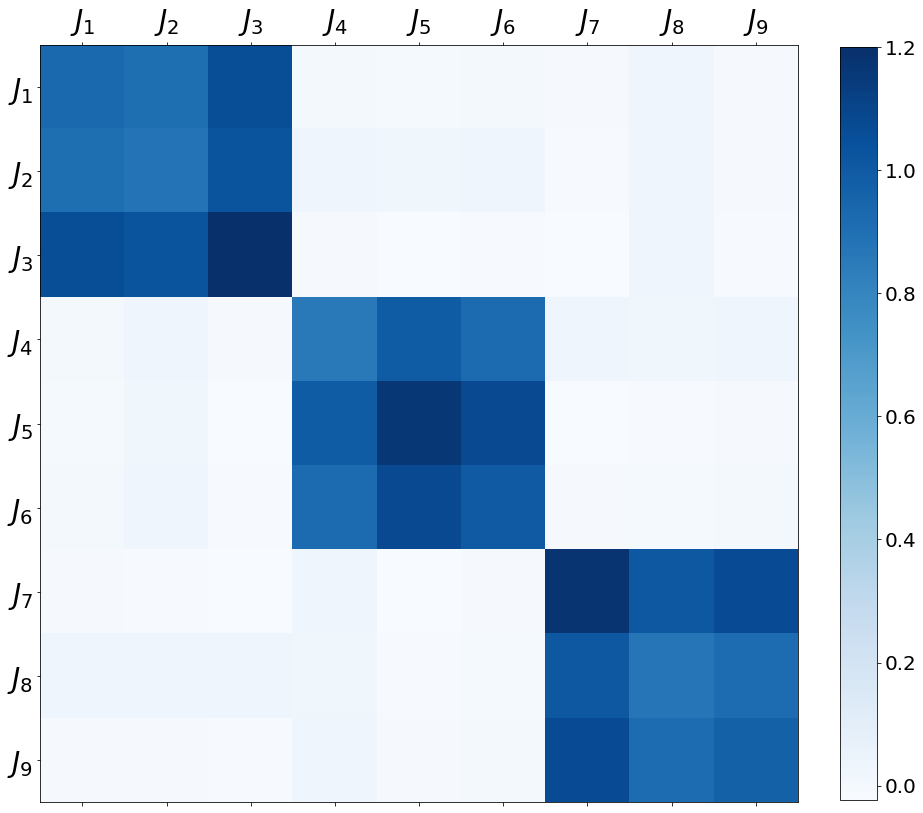

In [20]:
# Fig. S3

fig, ax = plt.subplots(figsize=(15,15))

min_val, max_val = -1, 1

intersection_matrix = QQ.T
cax=ax.matshow(intersection_matrix, cmap=plt.cm.Blues)
cbar=fig.colorbar(cax, fraction=0.045)
cbar.ax.tick_params(labelsize=20) 
alpha = [r"$B_1$",r"$B_2$"]
beta = [r"$J_1$",r"$J_2$",r"$J_3$",r"$J_4$",r"$J_5$",r"$J_6$",r"$J_7$",r"$J_8$",r"$J_9$"]
ax.set_xticklabels(beta,size=28)
ax.set_yticklabels(beta,size=28)
xaxis = np.arange(len(beta))
yaxis=np.arange(len(beta))
ax.set_xticks(xaxis)
ax.set_yticks(yaxis)
#plt.savefig("heat_map_Q_9_2_15000_ordered.pdf",bbox_inches="tight")
plt.show();

## Dependence on the variance of the initialization

In [21]:
variances=np.array([10**-1,10**-2,10**-3,10**-4,10**-5,10**-6,10**-9])

In [23]:
error_=[]
for var_ in variances:   
    print(var_)
    a=Committee_machine(K=2,M=2,eta=0.5,alpha=np.sqrt(2)/2,beta=1/np.sqrt(2),tStop=1200,var=var_,a=6)
    
    error_.append(a.epsilon())

0.1
0.01
0.001
0.0001
1e-05
1e-06
1e-09


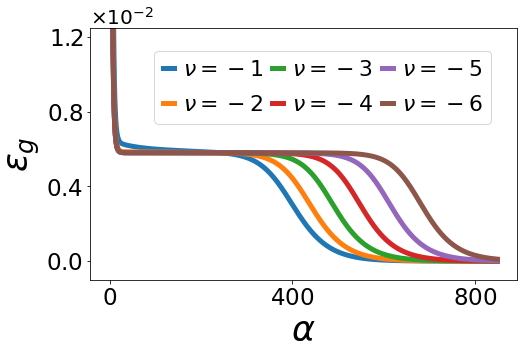

In [26]:
# modified Fig. S1
fig=plt.figure(figsize=(8,5))
ax = plt.axes()
color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','yellow','darkblue']
for i in range(0,6):
    a=0
    b=850
    plt.plot(error_[0][0][slice(a,b)],(error_[i][1][slice(a,b)]),linewidth=5,color=color[i])



plt.xlabel(r"$\alpha$",size=35)
plt.ylabel(r"$\epsilon_g$",size=35)
plt.legend(["$\\nu=-1$","$\\nu=-2$","$\\nu=-3$",r"$\nu=-4$",r"$\nu=-5$",r"$\nu=-6$"],fontsize=22,loc=(0.15,0.62),labelspacing=0.7,ncol=3,handlelength=0.5,columnspacing=0.4,handletextpad=0.4)

plt.xticks([0,400,800],fontsize=23)
plt.yticks([0,0.004,0.008,0.012],fontsize=23)

plt.ylim(-0.001,0.0125)

plt.gcf().subplots_adjust(bottom=0.22,left=0.18,top=0.92,right=0.92)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,10),useMathText=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,10),useMathText=True)
plt.gca().yaxis.offsetText.set_fontsize(20)
fig.patch.set_facecolor(None,)
fig.patch.set_alpha(0)
#plt.savefig("MA_eascape_plateau_referee2.pdf",dpi=1200)#,bbox_inches="tight")
plt.show();

## generalization error for teacher size M=3

In [ ]:
error2=[]
R0=0
Q0=0
for l in [3,6,9,12]:
    print(l)
    a2=Committee_machine(K=l,M=3,eta=l/np.sqrt(3),alpha=np.sqrt(3)/l,beta=1/np.sqrt(3),tStop=12000,var=10**-4,R0=R0,Q0=Q0,a=6,N=10000)
    error2.append(a2.epsilon())

In [ ]:
err=[]
for i in range(4):
    err.append(error2[i][1])
err=np.array(err)
err.shape

In [ ]:
df=pd.DataFrame(err)

In [27]:
# if saved upload data here
#df=pd.read_csv("gen_M3_4K.csv",sep=";",header=None)

In [28]:
df=df.drop([0],axis=1)

In [29]:
error3=df.values

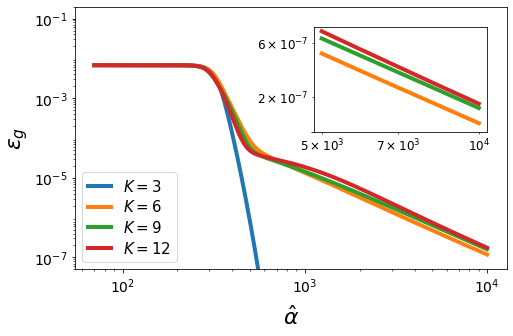

In [30]:
fig=plt.figure(figsize=(8,5))
ax = plt.axes()
t = np.arange(0., 500000, 1)
color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','yellow','darkblue']
for i in [0,1,2,3]:
    a=70
    b=10000
    plt.loglog(t[slice(a,b)],(error3[i][slice(a,b)]),linewidth=4,color=color[i])

plt.xlabel(r"$\hat{\alpha}$",size=22,labelpad=10)
plt.ylabel(r"$\epsilon_g$",size=22)
plt.legend([r"$K=3$",r"$K=6$",r"$K=9$",r"$K=12$"],fontsize=15,loc="lower left",labelspacing=0.3,ncol=1,handlelength=1.5,columnspacing=0.4,handletextpad=0.8)


plt.xticks(fontsize=14)
plt.yticks([10**-1,10**-3,10**-5,10**-7],fontsize=14)

plt.ylim(top=0.2,bottom=0.00000005)
plt.gcf().subplots_adjust(bottom=0.15,left=0.15)
plt.gca().yaxis.offsetText.set_fontsize(15)
fig.patch.set_facecolor(None,)
fig.patch.set_alpha(0)

axins2 = inset_axes(ax, width="40%", height="40%",loc=1,borderpad=2)

for i in [1,2,3]:
    a=5000
    b=10000
    axins2.loglog(t[slice(a,b)],np.array(error3[i][slice(a,b)]),linewidth=4,color=color[i])
for axi in [ axins2]:
    axi.tick_params(labelleft=False,labelbottom=False)

axins2.set_xticks([])

axins2.tick_params(axis="x",labelsize=12)
axins2.tick_params(axis="y",labelsize=12)

plt.gca().yaxis.offsetText.set_fontsize(10)
locmin2 = matplotlib.ticker.LogLocator(base=10.0,subs=(10,5,7),numticks=12)
axins2.xaxis.set_minor_locator(locmin2)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(6,2),numticks=12)
axins2.yaxis.set_minor_locator(locmin)
axins2.tick_params(axis='both', which='minor', labelsize=12)
plt.ylim(10**-7)
#plt.savefig("gen_M3_inset.pdf",bbox_inches="tight")
plt.show();

## non integer Z=K/M

In [ ]:
# what happens if K/M is non integer ratio
# Heatmap reveals interesting properties

R52=[]
Q52=[]
a2=Committee_machine(K=5,M=2,eta=1,alpha=np.sqrt(2)/5,beta=1/np.sqrt(2),tStop=10000,var=10**-4,a=6,N=10000,O=1)
solution2=a2.sol()
R52=solution2.y[slice(0,10)]
Q52=solution2.y[slice(10,10+25)]

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

min_val, max_val = -1, 1

intersection_matrix = (R42[:,9999].reshape((5,2)).T)
cax=ax.matshow(intersection_matrix, cmap=plt.cm.Blues,)
cbar=fig.colorbar(cax,orientation="horizontal",pad=0.02,)
cbar.ax.tick_params(labelsize=25)
alpha = [r"$J_1$",r"$J_1$",r"$J_2$",r"$J_3$",r"$J_4$",r"$J_5$",r"$J_6$",r"$J_7$",r"$J_8$",r"$J_9$"]
beta=[r"$B_1$",r"$B_1$",r"$B_2$",r"$B_3$",]
ax.set_xticklabels(alpha,size=33)
ax.set_yticklabels(beta,size=33)
#plt.savefig("heat_map_R_9_3_2.pdf",bbox_inches="tight")
plt.show();

In [90]:
# what happens if K/M is non integer ratio
# Fig. S5 for \hat{\alpha}=2000 instead of \hat{\alpha}=20000 for demonstration purposes
# for \hat{\alpha}=20000 just extend the parameter in the code
#error_mit_a=[]
for l in [4,5,8]:
    print(l)
    a2=Committee_machine(K=l,M=3,eta=l/np.sqrt(3),alpha=np.sqrt(3)/l,beta=1/np.sqrt(3),tStop=2000,O=1,var=10**-4,a=6,N=10000)
    error_mit_a.append(a2.epsilon())

8


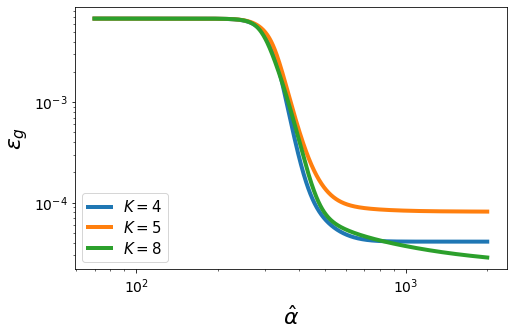

In [91]:
fig=plt.figure(figsize=(8,5))
ax = plt.axes()

color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','yellow','darkblue']
for i in [0,1,2]:
    a=70
    b=2000
    plt.loglog(error_mit_a[0][0][slice(a,b)],(error_mit_a[i][1][slice(a,b)]),linewidth=4,color=color[i])
plt.xlabel(r"$\hat{\alpha}$",size=22,labelpad=10)
plt.ylabel(r"$\epsilon_g$",size=22)
plt.legend([r"$K=4$",r"$K=5$",r"$K=8$"],fontsize=15,loc="lower left",labelspacing=0.3,ncol=1,handlelength=1.5,columnspacing=0.4,handletextpad=0.8)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15,left=0.15)
plt.gca().yaxis.offsetText.set_fontsize(15)
fig.patch.set_facecolor(None,)
fig.patch.set_alpha(0)

#plt.savefig("non_integer_ratio_M3.pdf",bbox_inches="tight")
plt.show();